In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from geopandas import GeoDataFrame
# And some functions we will need
from scipy.special import logit
from shapely import Point
from statsmodels.discrete.discrete_model import Logit
import statsmodels.api as sm


# start by bringing in the dataset from the previous step
set_df = pd.read_pickle("../data/set_df.pkl")
elevation_xa = pd.read_pickle("../data/elevation_xa.pkl")
species_df = pd.read_pickle("../data/species_df.pkl")
species_code_lookup = pd.read_pickle("../data/species_code_lookup.pkl")

# now we will want to create a dict to manage every we want to run in the logistic regressions
# species_dict = dict()
# for key in species_code_lookup.keys():
#     species_dict[key] = dict(name=species_code_lookup[key], predictors=)
# 
default_predictors = ['latitude', 'longitude', 'elevation']
species_dict = {
    'American plaice': {"predictors": default_predictors},
    'Atlantic cod': {"predictors": default_predictors},
    'Atlantic herring': {"predictors": default_predictors},
    'Redfish unidentified': {"predictors": default_predictors},
    'American lobster': {"predictors": default_predictors},
    'Snow crab': {"predictors": default_predictors},
}

In [583]:
set_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7257 entries, 11 to 166605
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   set_id                7257 non-null   int64         
 1   latitude              7257 non-null   float64       
 2   longitude             7257 non-null   float64       
 3   dt                    7257 non-null   datetime64[ns]
 4   elevation             7257 non-null   int32         
 5   American plaice       7257 non-null   bool          
 6   Atlantic cod          7257 non-null   bool          
 7   Atlantic herring      7257 non-null   bool          
 8   Redfish unidentified  7257 non-null   bool          
 9   American lobster      7257 non-null   bool          
 10  Snow crab             7257 non-null   bool          
dtypes: bool(6), datetime64[ns](1), float64(2), int32(1), int64(1)
memory usage: 354.3 KB


In [12]:

# For each species, we will fit a model
species_list = list(species_dict.keys())
for species in species_list:
    mydict = species_dict[species]
    predictors = mydict["predictors"]
    m = Logit(set_df[species], sm.add_constant(set_df[predictors]))
    m = m.fit()
    mydict["model"] = m
    

Optimization terminated successfully.
         Current function value: 0.349219
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410499
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.537318
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.276586
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.189613
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.599244
         Iterations 5


In [13]:

# Let's get a table of the parameter estimations for each species and indicate whether or not they are significant
param_df = pd.DataFrame(columns=["const"] + default_predictors)


def get_coef_display(row):
    mystr = str(round(row["Coef."], 4))
    p = row["P>|z|"]
    if p <= 0.001:
        mystr += " [***]"
    elif p <= 0.01:
        mystr += " [**]"
    elif p <= 0.05:
        mystr += " [*]"
    return mystr


for species in species_list:
    m = species_dict[species]["model"]
    summary = m.summary2()
    temp_param_df = summary.tables[1]
    params = temp_param_df.apply(get_coef_display, axis=1)
    param_df.loc[species] = params

param_df

,const,latitude,longitude,elevation
American plaice,-30.0087 [***],1.444 [***],0.5609 [***],0.0131 [***]
Atlantic cod,-30.3012 [***],1.0935 [***],0.2946 [***],0.0163 [***]
Atlantic herring,39.4171 [***],-1.5793 [***],-0.5565 [***],NaN
Redfish unidentified,-17.6596 [***],0.5059 [***],0.1757 [***],-0.038 [***]
American lobster,55.5688 [***],-1.9333 [***],-0.5996 [***],0.1006 [***]
Snow crab,-31.5677 [***],0.9373 [***],0.1946 [***],NaN


In [14]:

# based on the above, we will not use the `elevation` predictor for herring and snowcrab models

# species_dict["Atlantic herring"]["predictors"] = ["latitude", "longitude"]
# species_dict["Snow crab"]["predictors"] = ["latitude", "longitude"]

# and now we will have to re-run the models
for species in species_list:
    mydict = species_dict[species]
    predictors = mydict["predictors"]
    m = Logit(set_df[species], set_df[predictors])
    m = m.fit()
    mydict["model"] = m


Optimization terminated successfully.
         Current function value: 0.359037
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.422426
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.278567
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.210431
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.621467
         Iterations 5


In [15]:

for species in species_list:
    set_df[f"p_{species}"] = species_dict[species]["model"].predict(set_df[species_dict[species]["predictors"]])

set_df.head()



,set_id,latitude,longitude,dt,elevation,American plaice,Atlantic cod,Atlantic herring,Redfish unidentified,American lobster,Snow crab,p_American plaice,p_Atlantic cod,p_Atlantic herring,p_Redfish unidentified,p_American lobster,p_Snow crab
11,1,47.966667,-65.116667,1971-09-07 11:15:00,-87,True,True,False,False,False,False,0.742560,0.739406,0.669603,0.161558,0.004147,0.510553
23,2,47.933333,-65.250000,1971-09-07 12:45:00,-73,True,True,False,False,False,False,0.747351,0.761369,0.698959,0.095442,0.019126,0.493988
24,3,47.916667,-65.516667,1971-09-07 15:05:00,-48,True,True,True,False,False,False,0.759498,0.799379,0.743287,0.034769,0.231495,0.467207
0,4,48.016667,-64.766667,1971-09-07 08:25:00,-80,True,True,True,False,False,False,0.801242,0.783987,0.595767,0.134403,0.006161,0.549154
35,5,48.216667,-64.483333,1971-09-08 10:25:00,-96,True,True,False,False,False,False,0.830994,0.784135,0.491723,0.244544,0.000826,0.599461


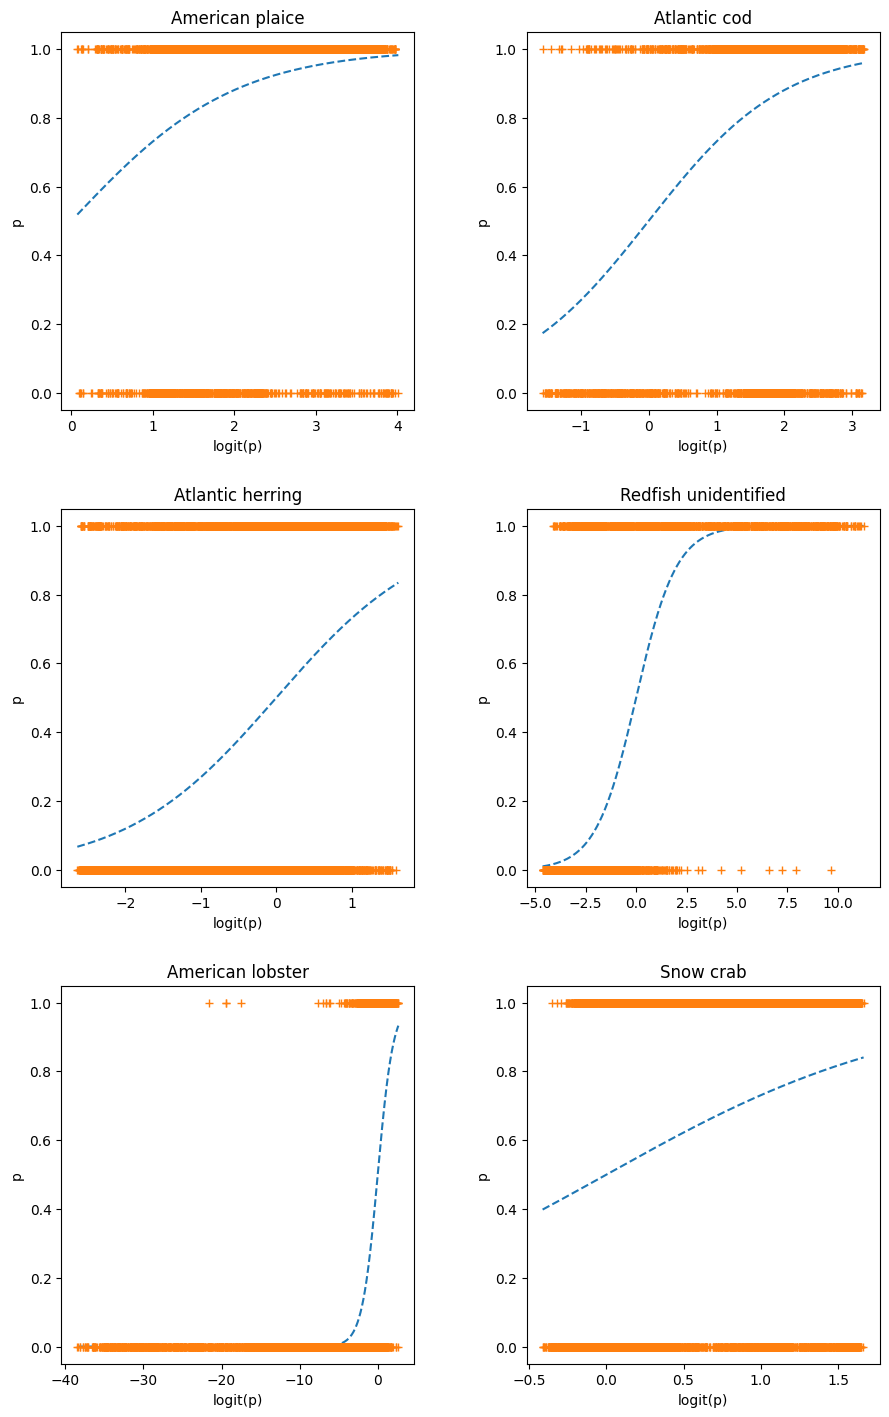

In [16]:

# plot relationship between values of logit(p) and p
# we will also display the actual values of the response

# create the figure and plot
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(ncols=2, nrows=3, figsize=(10, 15))
fig.tight_layout(pad=5)
axs = [ax1, ax2, ax3, ax4, ax5, ax6]


def generate_logit_plot(ax, species):
    p_attr = f'p_{species}'
    temp_df = set_df.sort_values(p_attr)
    ax.plot(logit(temp_df[p_attr]), temp_df[p_attr], '--')
    ax.plot(logit(temp_df[p_attr]), temp_df[species], '+')
    ax.set_title(species)
    ax.set_xlabel('logit(p)')
    ax.set_ylabel('p')


for i in range(0, 6):
    generate_logit_plot(axs[i], species_list[i])

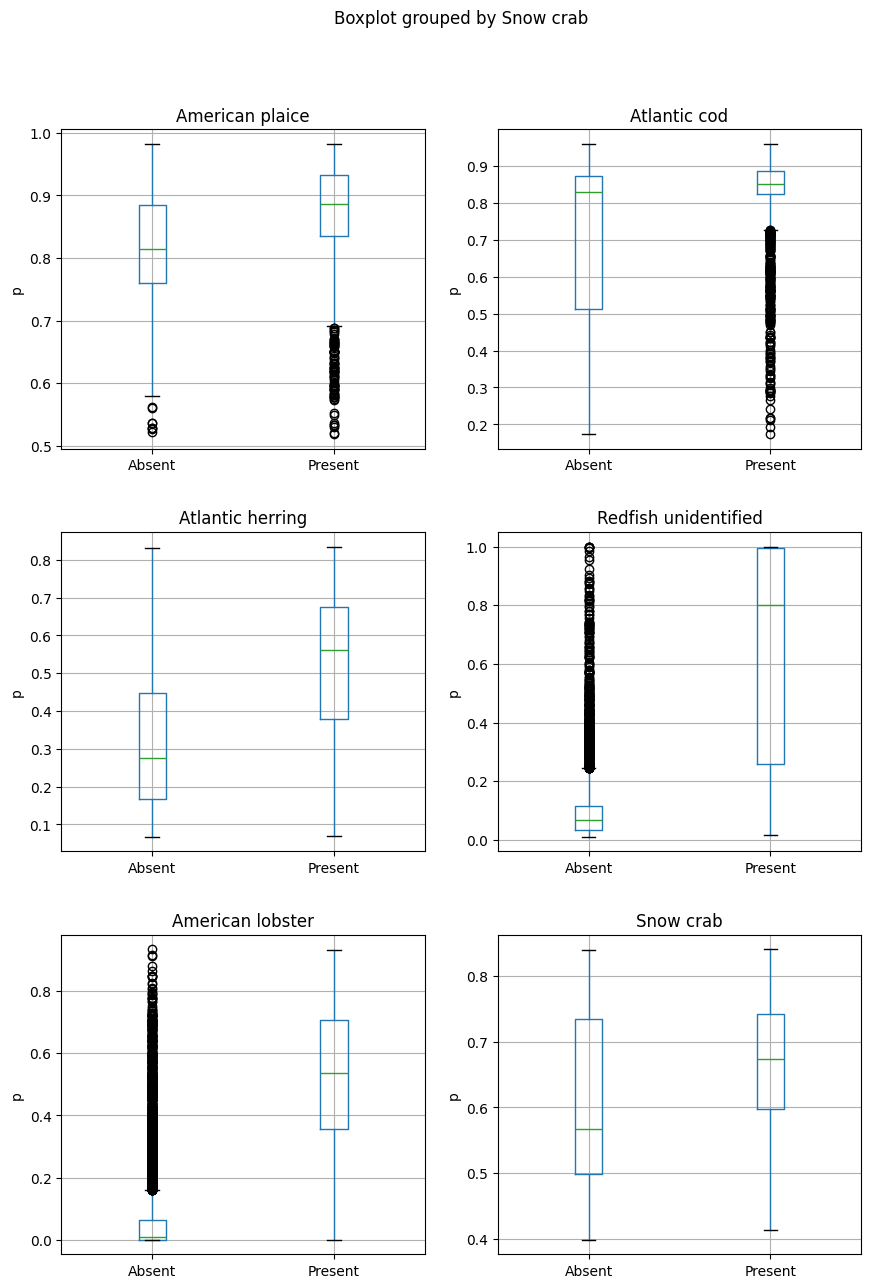

In [17]:

# create a box plot of the distribution of estimated odds for both values of the actual response

# create the figure and plot
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(ncols=2, nrows=3, figsize=(10, 15))
fig.tight_layout(pad=5)
axs = [ax1, ax2, ax3, ax4, ax5, ax6]


def generate_boxplot(ax, species):
    p_attr = f'p_{species}'
    temp_df = set_df.sort_values(p_attr)
    temp_df.boxplot(p_attr, species, ax=ax)
    ax.set_title(species)
    ax.set_xticks([1, 2], ['Absent', 'Present'])
    ax.set_xlabel('')
    ax.set_ylabel('p')


for i in range(0, 6):
    generate_boxplot(axs[i], species_list[i])

In [590]:

# In looking at the above, we can see the distribution of estimated odds for each level of the actual response. For example, it can be noted that in Species like redfish and lobster, the model seems to be doing a very good job in predicting the odds. In lobster, in cases where lobster was absent, the average model odds estimate was close to zero. In other species, the model did not do a good job in explaining this. 


In [18]:

# let's create a table that presents the ACC, MCC, Precision and Recall for discrimination threshold = 0.5

eval_df = pd.DataFrame(columns=["Converged", "Pseudo R-squared", "TP", "TN", "FP", "FN", "ACC", "MCC", "Precision", "Recall", "F-score"])

for species in species_list:
    m = species_dict[species]["model"]
    summary = m.summary2()
    temp_summary = summary.tables[0]
    converged = temp_summary[1][6]
    r2 = temp_summary[3][1]
    tn, fp, fn, tp = m.pred_table().flatten()
    if tn:
        acc = (tp + tn) / np.sum([tn, fp, fn, tp])
        mcc = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    else:
        acc = np.nan
        mcc = np.nan

    prc = tp / (tp + fp)
    rec = tp / (tp + fn)
    fscore = 2 * ((prc * rec) / (prc + rec))

    params = [converged, r2, tp, tn, fp, fn, acc, mcc, prc, rec, fscore]
    eval_df.loc[species] = params

eval_df

,Converged,Pseudo R-squared,TP,TN,FP,FN,ACC,MCC,Precision,Recall,F-score
American plaice,1.0000,0.067,6319.0,0.0,938.0,0.0,NaN,NaN,0.870745,1.000000,0.930907
Atlantic cod,1.0000,0.103,5882.0,310.0,994.0,71.0,0.853245,0.388693,0.855439,0.988073,0.916985
Atlantic herring,1.0000,0.155,1758.0,3559.0,814.0,1126.0,0.732672,0.433188,0.683515,0.609570,0.644428
Redfish unidentified,1.0000,0.479,1063.0,5502.0,116.0,576.0,0.904644,0.711781,0.901612,0.648566,0.754436
American lobster,1.0000,0.466,549.0,6047.0,238.0,423.0,0.908916,0.577182,0.697586,0.564815,0.624218
Snow crab,1.0000,0.045,4471.0,651.0,1927.0,208.0,0.705801,0.308250,0.698812,0.955546,0.807258


<Axes: >

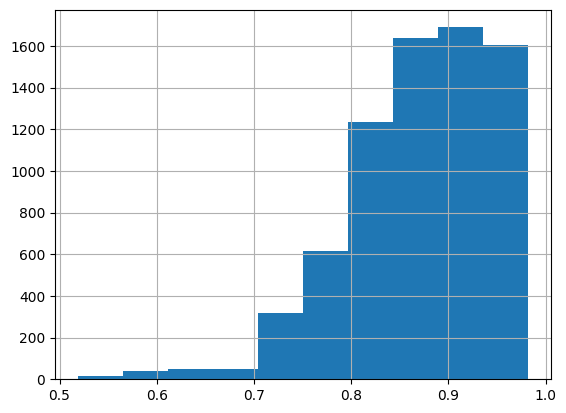

In [19]:
# Precision (also known as positive predictive value) is the fraction of correct estimates of the positive estimates:
# Recall (also known as the true positive rate, or sensitivity) is the fraction of correct estimates of the positive response
# Specificity (also known as the true negative rate) is the fraction of correct estimates of the negative response:
# F1-score (sometimes called F-measure, or Dice coefficient) is the harmonic mean of the precision and recall:


# what is going on with plaice?? 

m = species_dict["American plaice"]["model"]

set_df["p_American plaice"].hist()

# interesting.. plaice is  just going to bet on it always being present.


In [20]:

# now we need a table with the different discrimination thresholds

discr_th_df = pd.DataFrame(columns=["Default", "Max(Spec. + Sens.)", "Spec. = Sens.", "Max. ACC", "Max. MCC"])

for species in species_list:
    m = species_dict[species]["model"]
    summary = m.summary2()
    temp_summary = summary.tables[0]
    converged = temp_summary[1][6]
    r2 = temp_summary[3][1]
    tn, fp, fn, tp = m.pred_table().flatten()

    prc = tp / (tp + fp)
    rec = tp / (tp + fn)
    fscore = 2 * ((prc * rec) / (prc + rec))

    th = [0.5, r2, tp, tn, fp, fn, acc, mcc, prc, rec, fscore]
    eval_df.loc[species] = params

eval_df





,Converged,Pseudo R-squared,TP,TN,FP,FN,ACC,MCC,Precision,Recall,F-score
American plaice,1.0000,0.045,4471.0,651.0,1927.0,208.0,0.705801,0.30825,0.698812,0.955546,0.807258
Atlantic cod,1.0000,0.045,4471.0,651.0,1927.0,208.0,0.705801,0.30825,0.698812,0.955546,0.807258
Atlantic herring,1.0000,0.045,4471.0,651.0,1927.0,208.0,0.705801,0.30825,0.698812,0.955546,0.807258
Redfish unidentified,1.0000,0.045,4471.0,651.0,1927.0,208.0,0.705801,0.30825,0.698812,0.955546,0.807258
American lobster,1.0000,0.045,4471.0,651.0,1927.0,208.0,0.705801,0.30825,0.698812,0.955546,0.807258
Snow crab,1.0000,0.045,4471.0,651.0,1927.0,208.0,0.705801,0.30825,0.698812,0.955546,0.807258


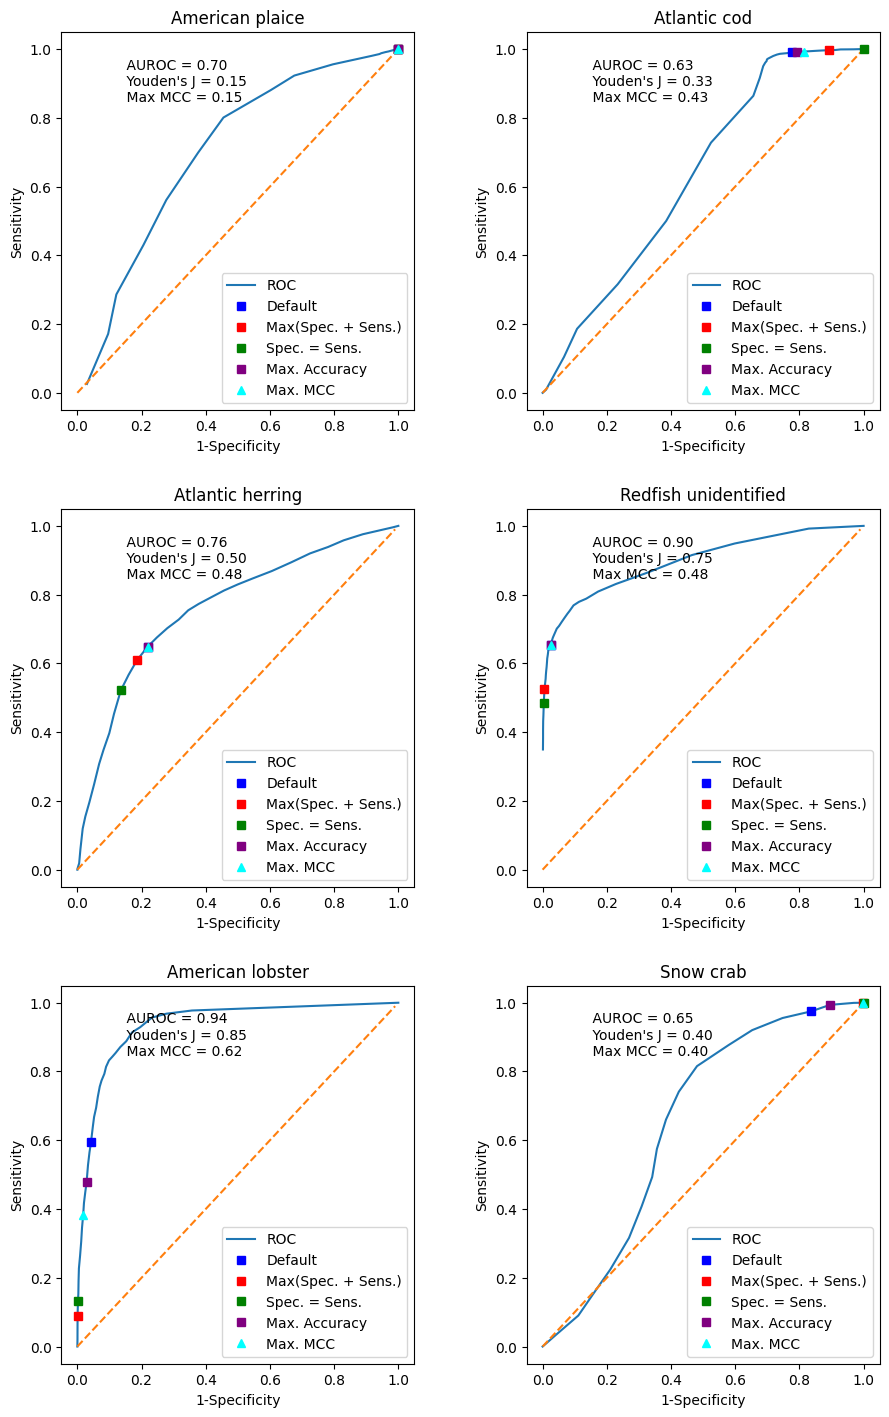

In [21]:


# create the figure and plot
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(ncols=2, nrows=3, figsize=(10, 15))
fig.tight_layout(pad=5)
axs = [ax1, ax2, ax3, ax4, ax5, ax6]

# Set discrimination thresholds
ths = np.arange(0., 1.0, 0.025)


def plot_roc(ax, species):
    """ Credit to lesson 08-01 from this course... """
    ax.set_title(species)
    ax.set_xlabel('1-Specificity')
    ax.set_ylabel('Sensitivity')

    # Containers
    sensitivity = []
    specificity = []
    accuracy = []
    matthews = []

    m = species_dict[species]["model"]

    # Main loop
    for th in ths:
        # Generate estimates
        conf_mat = m.pred_table(threshold=th)

        # Extract TN, FP, ...
        tn, fp, fn, tp = conf_mat.flatten()

        # Calculate sensitivity and specificity
        sens = (1. * tp) / (tp + fn)
        spec = (1. * tn) / (tn + fp)

        # Calculate ACC and MCC
        if tn and fp:
            # print(tn, fp, fn, tp)
            acc = (tp + tn) / np.sum(conf_mat)
            mcc = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
        else:
            acc = np.nan
            mcc = np.nan
        # Add to containers
        sensitivity.append(sens)
        specificity.append(spec)
        accuracy.append(acc)
        matthews.append(mcc)

    # Bind all the numbers together
    roc = pd.DataFrame({'discret_thr': ths,
                        'sensitivity': sensitivity,
                        'specificity': specificity,
                        '_specificity': [1 - x for x in specificity],
                        'accuracy': accuracy,
                        'matthews': matthews})

    # Sort by 1 - specificity so we can plot it easily
    roc = roc.sort_values(by="_specificity")
    ax.plot(roc._specificity, roc.sensitivity, label='ROC')
    ax.plot(np.arange(0., 1., 0.01), np.arange(0., 1., 0.01), '--')  # straight line x=y
    ax.legend(loc=4)

    # calculate the area under the curve
    auc = np.trapz(y=roc.sensitivity, x=roc._specificity)

    # Where threshold equal 0.5
    idx_default_th = np.where(roc.discret_thr == 0.5)[0][0]

    # Max sum of spec and sens
    idx_youdensj = np.argmax(roc.sensitivity + roc.specificity)

    # Balanced spec and sens
    idx_balance = np.argmin(np.abs(roc.sensitivity - roc.specificity))

    # Max accuracy
    idx_maxacc = np.argmax(roc.accuracy)

    # Max matthews
    idx_maxmcc = np.argmax(roc.matthews)

    ax.plot(roc._specificity[idx_default_th],
            roc.sensitivity[idx_default_th],
            's', color='blue',
            label='Default')

    ax.plot(roc._specificity[idx_youdensj],
            roc.sensitivity[idx_youdensj],
            's', color='red',
            label='Max(Spec. + Sens.)')

    ax.plot(roc._specificity[idx_balance],
            roc.sensitivity[idx_balance],
            's', color='green',
            label='Spec. = Sens.')

    ax.plot(roc._specificity[idx_maxacc],
            roc.sensitivity[idx_maxacc],
            's', color='purple',
            label='Max. Accuracy')

    ax.plot(roc._specificity[idx_maxmcc],
            roc.sensitivity[idx_maxmcc],
            '^', color='cyan',
            label='Max. MCC')

    ax.legend(loc=4)
    ax.text(x=0.1, y=0.8, s=f"""
    AUROC = {auc:.2f}
    Youden's J = {roc.discret_thr[idx_youdensj]:.2f}
    Max MCC = {roc.discret_thr[idx_maxmcc]:.2f}
    """, fontsize=10)
    # print("Area under ROC curve = %1.2f" )


for i in range(0, 6):
    plot_roc(axs[i], species_list[i])
# plot_roc(axs[i], species_list[1])


In [22]:

# now for the piece de resistance!  Let's create some maps for predicting occurrences 

# let's go back to the elevation dataarray

# transform it to a dataframe. The indexes are lat and long but we want these to be columns in the dataframe.
elevation_df = elevation_xa.to_dataframe()
elevation_df = elevation_df.reset_index()

# make sure the columns match up with the predictor names
elevation_df.rename(columns={"lat": "latitude", "lon": "longitude"}, inplace=True)

# now, we will add a column for each species that predicts occurrence.
for species in species_list:
    model = species_dict[species]["model"]
    predictors = species_dict[species]["predictors"]
    elevation_df[f'p_{species}'] = model.predict(elevation_df[predictors])

elevation_df.head()



,latitude,longitude,elevation,p_American plaice,p_Atlantic cod,p_Atlantic herring,p_Redfish unidentified,p_American lobster,p_Snow crab
0,45.022917,-68.418750,86,0.125879,0.628382,0.998052,0.000059,1.0,0.064929
1,45.022917,-68.414583,87,0.127267,0.631795,0.998046,0.000056,1.0,0.065023
2,45.022917,-68.410417,88,0.128669,0.635195,0.998040,0.000054,1.0,0.065117
3,45.022917,-68.406250,93,0.134645,0.650611,0.998034,0.000044,1.0,0.065211
4,45.022917,-68.402083,95,0.137287,0.656897,0.998027,0.000041,1.0,0.065306


In [ ]:

# plot a heatmap for each species

# create the figure and plot
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(ncols=2, nrows=3, figsize=(10, 15))
fig.tight_layout(pad=5)
axs = [ax1, ax2, ax3, ax4, ax5, ax6]


def plot_heatmap(ax, species):
    # change the array back to the original shape 
    prob_array = elevation_df[f"p_{species}"].to_numpy().reshape(elevation_xa.data.shape)
    # clone the elevation xarray data array to use for the probability mapping 
    prob_xa = elevation_xa.copy()
    prob_xa.data = prob_array
    # add some useful attributes
    prob_xa.attrs = {
        "long_name": "Probability of occurrence",
        "units": "p",
    }
    # plot the map
    prob_xa.plot(ax=ax, cmap="gist_heat")
    # let's overlay the sites where there were positive observations
    geometry = [Point(xy) for xy in zip(set_df['longitude'], set_df['latitude'])]
    gdf = GeoDataFrame(set_df, geometry=geometry)
    gdf = gdf.set_crs(epsg=4269)
    mask = gdf[species] == True
    gdf[mask].plot(ax=ax, marker=".", color='blue', markersize=1, label="present")

    # now we will overlay with land polygons
    # this geojson is from here: https://open.canada.ca/data/en/dataset/85efc01b-163f-ebba-2378-c43eadfb3b3f
    canada = gpd.read_file("../data/Canada_Provinical_boundaries_April2022_3931220444258526365.geojson")
    canada = canada.to_crs(epsg=4269)  # it is in a weird projection
    canada.plot(ax=ax, color='grey')

    # set graph props
    ax.set_title(f'Distribution Map of {species.title()}', fontsize=10)
    ax.set_xlabel('Longitude', fontsize=10)
    ax.set_ylabel('Latitude', fontsize='medium')
    ax.set_xlim((np.min(set_df["longitude"]), np.max(set_df["longitude"])))
    ax.set_ylim((np.min(set_df["latitude"]), np.max(set_df["latitude"])))


for i in range(0, 6):
    plot_heatmap(axs[i], species_list[i])